In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotlib as mpl
from cmcrameri import cm
import cartopy.feature as cf
import cartopy.feature as cf
import regionmask
#import pearsonr
from scipy.stats import pearsonr

In [6]:
folder_ts = r'Data\Datasets\amz\ts'
folder_metric = r'Data\Datasets\amz\oscilations'
datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')
regions_mask = regionmask.from_geopandas(regions, names='Region')

In [7]:
#open MEI index txt file
mei = pd.read_csv(r'Data\Indices_oscilations\meiv2.data.txt',skiprows=1, header=None, skipfooter=5, sep='\s+')
mei.rename({0:'year'}, axis=1, inplace=True)
mei = mei.melt(id_vars=['year'], var_name='Month', value_name='MEI')
#from year and month columns, create a Date column
mei['Date'] = pd.to_datetime(mei['year'].astype(str) + '-' + mei['Month'].astype(str))
mei = mei[['Date', 'MEI']]
amo = pd.read_csv(r'Data\Indices_oscilations\amo.txt',skiprows=1, sep='\s+')
amo['Date'] = pd.to_datetime(amo['Year'].astype(str) + '-' + amo['month'].astype(str))
amo.rename({'SSTA':'AMO'}, axis=1, inplace=True)
amo = amo[['Date', 'AMO']]
indices = mei.merge(amo, on='Date')
#only indices in the 2001-2020 period
indices = indices[(indices['Date'] >= '2001-01-01') & (indices['Date'] <= '2020-12-01')]
enso_df = indices[['Date', 'MEI']].copy().set_index('Date')
amo_df = indices[['Date', 'AMO']].copy().set_index('Date')

C:\Users\luisg\AppData\Local\Temp\ipykernel_15208\2216339250.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  mei = pd.read_csv(r'Data\Indices_oscilations\meiv2.data.txt',skiprows=1, header=None, skipfooter=5, sep='\s+')


In [8]:
def corr_index(ds, enso_df, amo_df):
    # Initialize arrays to store corr coefficients and p-values
    corr_mei = np.zeros((len(ds.lat), len(ds.lon)))
    p_value_mei = np.zeros((len(ds.lat), len(ds.lon)))
    corr_amo = np.zeros((len(ds.lat), len(ds.lon)))
    p_value_amo = np.zeros((len(ds.lat), len(ds.lon)))

    # Compute the corr between each pixel's timeseries and the ENSO and AMO indices, along with p-values
    for i, lat in enumerate(ds.lat):
        for j, lon in enumerate(ds.lon):
            pixel_timeseries = ds.sel(lat=lat, lon=lon).pr
            if np.isnan(pixel_timeseries).all():
                # If all values in the pixel_timeseries are NaN, set corr and p-values to NaN
                corr_mei[i, j] = np.nan
                p_value_mei[i, j] = np.nan
                corr_amo[i, j] = np.nan
                p_value_amo[i, j] = np.nan
            else:
                corr_mei[i, j], p_value_mei[i, j] = pearsonr(pixel_timeseries, enso_df.values.squeeze())
                corr_amo[i, j], p_value_amo[i, j] = pearsonr(pixel_timeseries, amo_df.values.squeeze())

    # Create a new Xarray dataset with both corr coefficients and p-values as variables
    corr_ds = xr.Dataset(
        {
            "corr_MEI": (["lat", "lon"], corr_mei),
            "p_value_MEI": (["lat", "lon"], p_value_mei),
            "corr_AMO": (["lat", "lon"], corr_amo),
            "p_value_AMO": (["lat", "lon"], p_value_amo),
        },
        coords={"lat": ds.lat, "lon": ds.lon},
    )

    return corr_ds
#corr_ds.to_netcdf(os.path.join(folder_metric, dataset))

In [62]:
for dataset in datasets:
    #read file of dataset in folder_clean
    file_path = glob(os.path.join(folder_ts, dataset + '.nc'))
    ds = xr.open_dataset(file_path[0])
    ds_std = ds.groupby('time.month').apply(lambda x: (x - x.mean()) / x.std())
    corr_ds = corr_index(ds_std, enso_df, amo_df)
    #corr_ds.to_netcdf(os.path.join(folder_metric, dataset + '.nc'))
    print(dataset + ' done!')

# station

In [15]:
#do the correlation for each station in
stations = gpd.read_file(r'Data\Evaluation\stations_amz_ANA.geojson')
df_stat= pd.read_pickle(r'Data\Evaluation\amz_01_20_20bet.pkl').sort_values(by=['Code', 'Date']).reset_index(drop=True)


In [26]:
df_indices = df_stat.groupby('Code').apply(lambda x: pearsonr(x['Total'], enso_df['MEI'])[0]).reset_index().rename({0:'corr_MEI'}, axis=1)
df_indices['p_value_MEI'] = df_stat.groupby('Code').apply(lambda x: pearsonr(x['Total'], enso_df['MEI'])[1]).reset_index(drop=True)
df_indices['corr_AMO'] = df_stat.groupby('Code').apply(lambda x: pearsonr(x['Total'], amo_df['AMO'])[0]).reset_index(drop=True)
df_indices['p_value_AMO'] = df_stat.groupby('Code').apply(lambda x: pearsonr(x['Total'], amo_df['AMO'])[1]).reset_index(drop=True)
stations = stations.merge(df_indices, on='Code')
stations.to_file(os.path.join(folder_metric, 'stations.geojson'), driver='GeoJSON')

<AxesSubplot: xlabel='Date'>

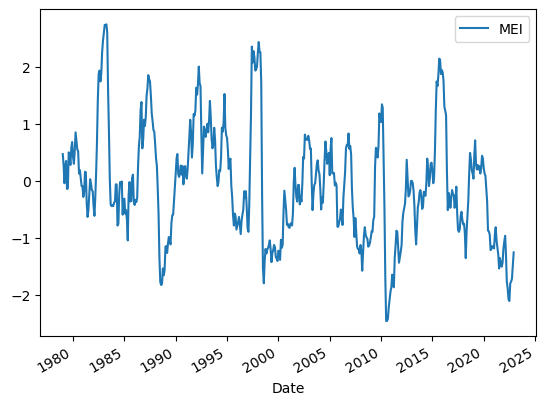

In [26]:
mei.plot(x='Date', y='MEI')

In [31]:
#open MEI index txt file
mei = pd.read_csv(r'Data\Indices_oscilations\meiv2.data.txt',skiprows=1, header=None, skipfooter=5, sep='\s+')
mei.rename({0:'year'}, axis=1, inplace=True)
mei = mei.melt(id_vars=['year'], var_name='Month', value_name='MEI')
#from year and month columns, create a Date column
mei['Date'] = pd.to_datetime(mei['year'].astype(str) + '-' + mei['Month'].astype(str))
mei = mei[['Date', 'MEI']]
amo = pd.read_csv(r'Data\Indices_oscilations\amo.txt',skiprows=1, sep='\s+')
amo['Date'] = pd.to_datetime(amo['Year'].astype(str) + '-' + amo['month'].astype(str))
amo.rename({'SSTA':'AMO'}, axis=1, inplace=True)
amo = amo[['Date', 'AMO']]
indices = mei.merge(amo, on='Date')
#only indices in the 2001-2020 period
indices = indices[(indices['Date'] >= '1981-01-01') & (indices['Date'] <= '2020-12-01')]
enso_df = indices[['Date', 'MEI']].copy().set_index('Date')
amo_df = indices[['Date', 'AMO']].copy().set_index('Date')

C:\Users\luisg\AppData\Local\Temp\ipykernel_15208\2649511619.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  mei = pd.read_csv(r'Data\Indices_oscilations\meiv2.data.txt',skiprows=1, header=None, skipfooter=5, sep='\s+')


In [33]:
ds = xr.open_dataset('Data\Datasets\clean\chirps.nc').sel(time=slice('1981-01-01', '2020-12-31'))
ds_std = ds.groupby('time.month').apply(lambda x: (x - x.mean()) / x.std())
corr_ds = corr_index(ds_std, enso_df, amo_df)

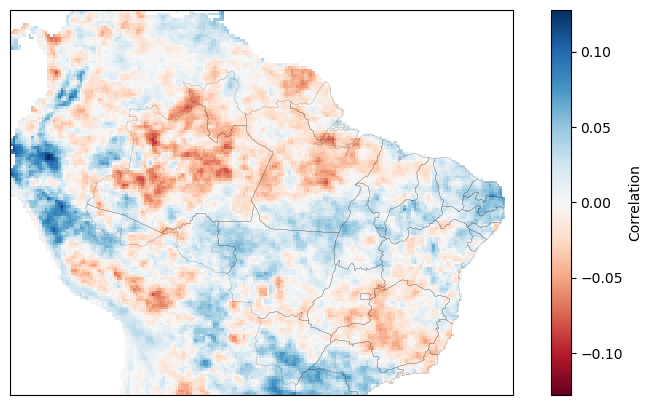

In [41]:
import cartopy.feature
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()})
corr_ds['corr_MEI'].plot(transform=ccrs.PlateCarree(), cmap='RdBu',  ax=ax, cbar_kwargs={'label': 'Correlation'})
#plot states
ax.add_feature(cartopy.feature.STATES, linewidth=0.1)

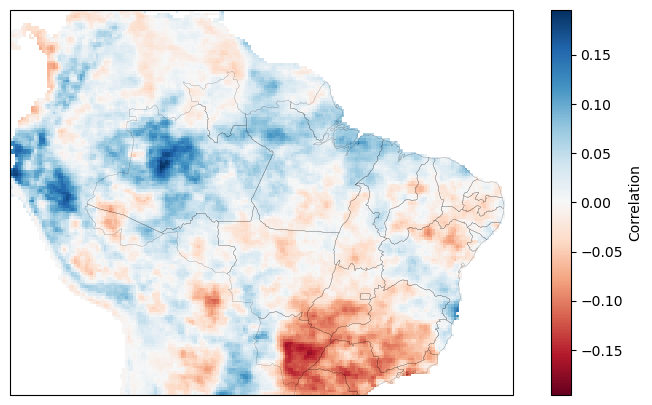

In [42]:
indices = mei.merge(amo, on='Date')
#only indices in the 2001-2020 period
indices = indices[(indices['Date'] >= '2001-01-01') & (indices['Date'] <= '2020-12-01')]
enso_df = indices[['Date', 'MEI']].copy().set_index('Date')
amo_df = indices[['Date', 'AMO']].copy().set_index('Date')
ds = xr.open_dataset('Data\Datasets\clean\chirps.nc').sel(time=slice('2001-01-01', '2020-12-31'))
ds_std = ds.groupby('time.month').apply(lambda x: (x - x.mean()) / x.std())
corr_ds = corr_index(ds_std, enso_df, amo_df)

import cartopy.feature
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()})
corr_ds['corr_MEI'].plot(transform=ccrs.PlateCarree(), cmap='RdBu',  ax=ax, cbar_kwargs={'label': 'Correlation'})
#plot states
ax.add_feature(cartopy.feature.STATES, linewidth=0.1)

# test SOI

In [53]:
soi= pd.read_csv(r'Data\Indices_oscilations\SOI_std.txt',skiprows=4, header=None, skipfooter=8, sep='\s+')
soi.rename({0:'year'}, axis=1, inplace=True)
soi = soi.melt(id_vars=['year'], var_name='Month', value_name='SOI')
#from year and month columns, create a Date column
soi['Date'] = pd.to_datetime(soi['year'].astype(str) + '-' + soi['Month'].astype(str))
soi = soi[['Date', 'SOI']]

indices = soi.merge(amo, on='Date')
#only indices in the 2001-2020 period
indices = indices[(indices['Date'] >= '2001-01-01') & (indices['Date'] <= '2020-12-01')]
enso_df = indices[['Date', 'SOI']].copy().set_index('Date')
amo_df = indices[['Date', 'AMO']].copy().set_index('Date')

C:\Users\luisg\AppData\Local\Temp\ipykernel_15208\3989233779.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  soi= pd.read_csv(r'Data\Indices_oscilations\SOI_std.txt',skiprows=4, header=None, skipfooter=8, sep='\s+')


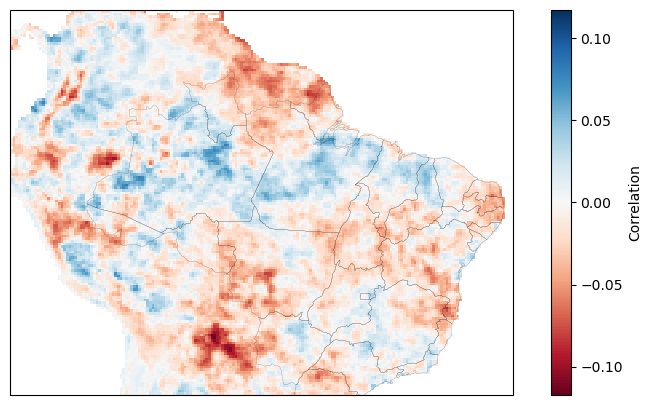

In [55]:
indices = soi.merge(amo, on='Date')
#only indices in the 1981-2020 period
indices = indices[(indices['Date'] >= '1981-01-01') & (indices['Date'] <= '2020-12-01')]
enso_df = indices[['Date', 'SOI']].copy().set_index('Date')
amo_df = indices[['Date', 'AMO']].copy().set_index('Date')
ds = xr.open_dataset('Data\Datasets\clean\chirps.nc').sel(time=slice('1981-01-01', '2020-12-31'))
ds_std = ds.groupby('time.month').apply(lambda x: (x - x.mean()) / x.std())
corr_ds = corr_index(ds_std, enso_df, amo_df)

import cartopy.feature
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()})
corr_ds['corr_MEI'].plot(transform=ccrs.PlateCarree(), cmap='RdBu_r',  ax=ax, cbar_kwargs={'label': 'Correlation'})
#plot states
ax.add_feature(cartopy.feature.STATES, linewidth=0.1)

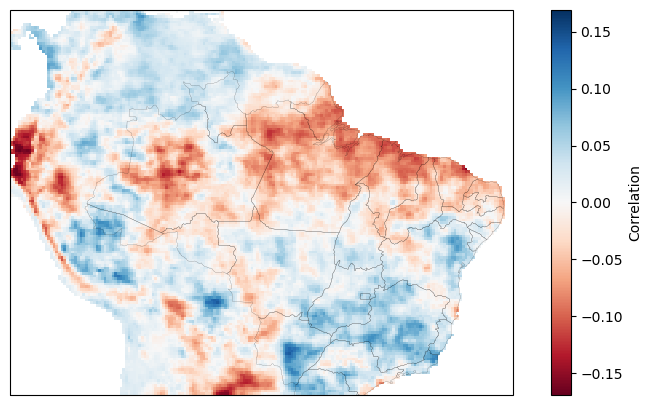

In [54]:
indices = soi.merge(amo, on='Date')
#only indices in the 2001-2020 period
indices = indices[(indices['Date'] >= '2001-01-01') & (indices['Date'] <= '2020-12-01')]
enso_df = indices[['Date', 'SOI']].copy().set_index('Date')
amo_df = indices[['Date', 'AMO']].copy().set_index('Date')
ds = xr.open_dataset('Data\Datasets\clean\chirps.nc').sel(time=slice('2001-01-01', '2020-12-31'))
ds_std = ds.groupby('time.month').apply(lambda x: (x - x.mean()) / x.std())
corr_ds = corr_index(ds_std, enso_df, amo_df)

import cartopy.feature
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()})
corr_ds['corr_MEI'].plot(transform=ccrs.PlateCarree(), cmap='RdBu',  ax=ax, cbar_kwargs={'label': 'Correlation'})
#plot states
ax.add_feature(cartopy.feature.STATES, linewidth=0.1)